In [1]:
entropy = [-1e-2, -1e-3, -1e-4, -1e-5, 0, 1e-5, 1e-4, 1e-3, 1e-2]
returns_mean = [1646.8, 2156.8, 1862.4, 2307.1, 1729.5, 1715.9, 2105.9, 2186.0, 1631.3]
returns_std = [867.06, 592.53, 599.78, 621.42, 674.28, 374.08, 535.31, 239.65, 350.54]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from functools import reduce
import seaborn as sns

sns.set(style="darkgrid")

In [2]:
directory_ent = "../data/ppo/ppo_hopper_ent_ent/"
directory_res = "../data/ppo/ppo_hopper_ent_res/"
raw_folders = [i for i in os.listdir(directory_ent) if os.path.isdir(os.path.join(directory_ent, i))]
raw_folders

['-1e-3', '-1e-4', '1e-3', '-1e-5', '1e-4', '-1e-2', '1e-2', '1e-5', '0e0']

In [3]:
float_folders = [float(i) for i in raw_folders]
float_folders.sort()
folders = [str(f"{i:2.0e}").replace("-0", "-").replace("+00", "0") for i in float_folders]
folders

['-1e-2', '-1e-3', '-1e-4', '-1e-5', '0e0', '1e-5', '1e-4', '1e-3', '1e-2']

In [4]:
experiments_ent = dict()
for i in folders:
    tmp = os.listdir(directory_ent + i)
    paths = []
    for j, file in enumerate(tmp):
        if file[-4:] == ".csv":
            paths.append(os.path.join(directory_ent, i, file))
    experiments_ent[i] = paths

experiments_res = dict()
for i in folders:
    tmp = os.listdir(directory_res + i)
    paths = []
    for j, file in enumerate(tmp):
        if file[-4:] == ".csv":
            paths.append(os.path.join(directory_res, i, file))
    experiments_res[i] = paths

In [5]:
def read_filelist_ent(filelist):
    data_list = []
    for i in filelist:
        dataset = pd.read_csv(i)
        dataset = dataset[["Step", "Value"]]
#         dataset.Step = dataset.Step.round(-4)
        dataset = dataset.drop_duplicates()
        data_list.append(dataset)
        
    dataset = reduce(lambda x, y: pd.merge(x, y, how="outer", on = 'Step'), data_list)
    dataset = dataset.sort_values(by="Step")
    
    dataset = dataset.fillna(method='ffill')
    dataset["mean"] = dataset.iloc[:,1:].mean(axis=1)
    dataset["max"] =  dataset.iloc[:,1:].max(axis=1)
    dataset["min"] =  dataset.iloc[:,1:].min(axis=1)
    dataset["std+"] =  dataset.iloc[:,1:].mean(axis=1) + dataset.iloc[:,1:].std(axis=1)
    dataset["std-"] =  dataset.iloc[:,1:].mean(axis=1) - dataset.iloc[:,1:].std(axis=1)
    dataset["Step"] = dataset["Step"] 
    dataset = dataset[dataset["Step"] <= 1000]
    return dataset

In [6]:
def plot_datasets_ent(files_exps, labels, title="Title"):
    #Plotting:
    for i, dataset in enumerate(files_exps):
        label = labels[i]
        sns.lineplot(dataset["Step"], dataset["mean"], linewidth=2, label=label) #mean curve.
        plt.fill_between(dataset["Step"], dataset["max"], dataset["min"], alpha=.2) #std curves.
    
    plt.ylim((-200,1200))
    plt.xlim((-40,900))
    plt.xlabel("# policy updates")
    plt.ylabel("policy Entropy")
    plt.title(title)
    plt.legend(loc="upper right")
#     plt.savefig(title.replace(" ", "_") + "_entropy_plot" + ".png", dpi=1200, format="png", pad_inches=0.28, bbox_inches="tight")

In [7]:
def read_filelist_res(filelist):
    data_list = []
    for i in filelist:
        dataset = pd.read_csv(i)
        dataset = dataset[["Step", "Value"]]
        dataset.Step = dataset.Step.round(-4)
        dataset = dataset.drop_duplicates()
        data_list.append(dataset)
        
    dataset = reduce(lambda x, y: pd.merge(x, y, how="outer", on = 'Step'), data_list)
    dataset = dataset.sort_values(by="Step")
    
    dataset = dataset.fillna(method='ffill')
    dataset["mean"] = dataset.iloc[:,1:].mean(axis=1)
    dataset["max"] =  dataset.iloc[:,1:].max(axis=1)
    dataset["min"] =  dataset.iloc[:,1:].min(axis=1)
    dataset["std+"] =  dataset.iloc[:,1:].mean(axis=1) + dataset.iloc[:,1:].std(axis=1)
    dataset["std-"] =  dataset.iloc[:,1:].mean(axis=1) - dataset.iloc[:,1:].std(axis=1)
    dataset["Step"] = dataset["Step"] / 1e6
    dataset = dataset[dataset["Step"] <= 1]
    return dataset

In [8]:
def plot_datasets_res(files_exps, labels, title="Title"):
    #Plotting:
    for i, dataset in enumerate(files_exps):
        label = labels[i]
        sns.lineplot(dataset["Step"], dataset["mean"], linewidth=2, label=label) #mean curve.
        plt.fill_between(dataset["Step"], dataset["std+"], dataset["std-"], alpha=.2) #std curves.
    
    plt.ylim((-100,3400))
    plt.xlabel("million steps")
    plt.ylabel("average return")
    plt.title(title)
    plt.legend(loc="upper left")
#     plt.savefig(title.replace(" ", "_") + "_result_plot" + ".png", dpi=1200, format="png", pad_inches=0.28, bbox_inches="tight")

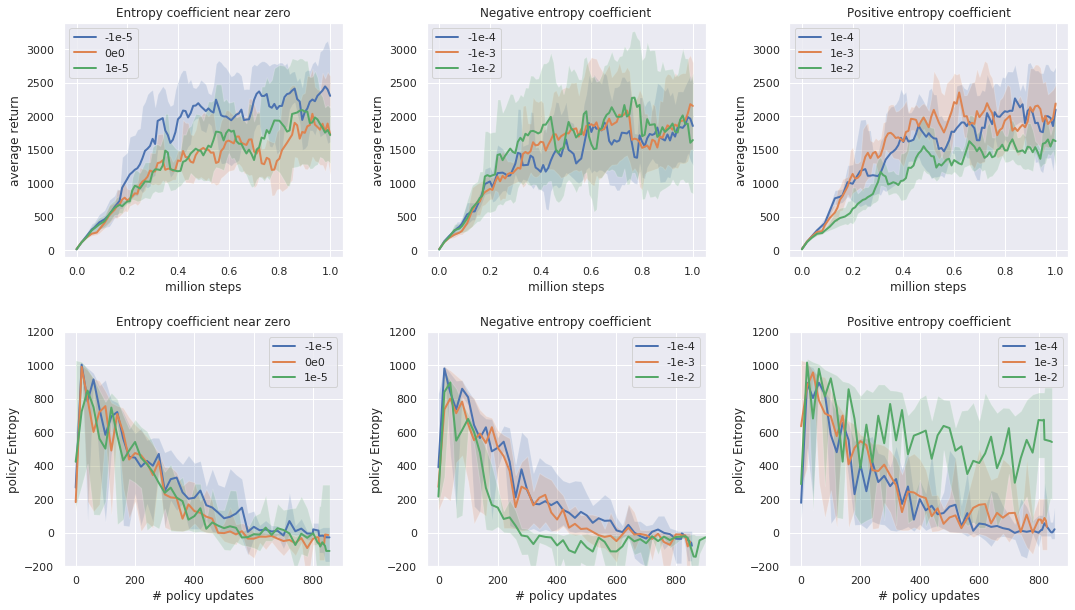

In [15]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
labels = ['-1e-5', '0e0', '1e-5']
files_exps = (read_filelist_res(experiments_res[i]) for i in labels)
plot_datasets_res(files_exps, labels, "Entropy coefficient near zero")

plt.subplot(2, 3, 2)
labels = ['-1e-4', '-1e-3', '-1e-2']
files_exps = [read_filelist_res(experiments_res[i]) for i in labels]
plot_datasets_res(files_exps, labels, "Negative entropy coefficient")

plt.subplot(2, 3, 3)
labels = ['1e-4', '1e-3', '1e-2']
files_exps = [read_filelist_res(experiments_res[i]) for i in labels]
plot_datasets_res(files_exps, labels, "Positive entropy coefficient")

plt.subplot(2, 3, 4)
labels = ['-1e-5', '0e0', '1e-5']
files_exps = (read_filelist_ent(experiments_ent[i]) for i in labels)
plot_datasets_ent(files_exps, labels, "Entropy coefficient near zero")

plt.subplot(2, 3, 5)
labels = ['-1e-4', '-1e-3', '-1e-2']
files_exps = [read_filelist_ent(experiments_ent[i]) for i in labels]
plot_datasets_ent(files_exps, labels, "Negative entropy coefficient")

plt.subplot(2, 3, 6)
labels = ['1e-4', '1e-3', '1e-2']
files_exps = [read_filelist_ent(experiments_ent[i]) for i in labels]
plot_datasets_ent(files_exps, labels, "Positive entropy coefficient")
plt.subplots_adjust(wspace=0.3)


plt.subplots_adjust(wspace=0.3, hspace=0.32)
plt.savefig("Entropy_coeff" + ".png", dpi=1200, format="png", pad_inches=0.28, bbox_inches="tight")

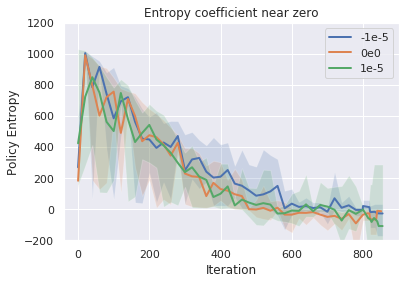

In [92]:
labels = ['-1e-5', '0e0', '1e-5']
files_exps = (read_filelist(experiments[i]) for i in labels)
plot_datasets(files_exps, labels, "Entropy coefficient near zero")

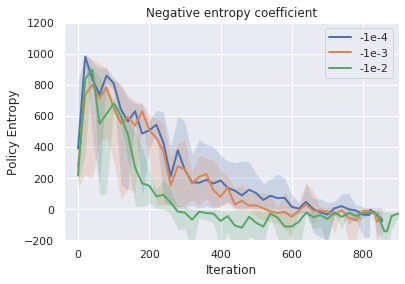

In [93]:
labels = ['-1e-4', '-1e-3', '-1e-2']
files_exps = [read_filelist(experiments[i]) for i in labels]
plot_datasets(files_exps, labels, "Negative entropy coefficient")

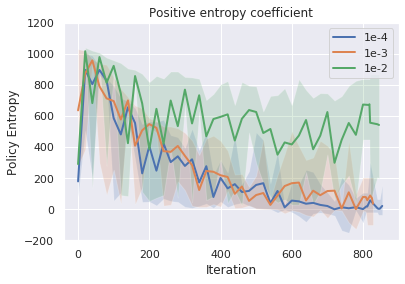

In [94]:
labels = ['1e-4', '1e-3', '1e-2']
files_exps = [read_filelist(experiments[i]) for i in labels]
plot_datasets(files_exps, labels, "Positive entropy coefficient")